In [121]:
import tensorflow as tf
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Dense, Masking, Dropout  # type: ignore
from tensorflow.keras.optimizers import Adam  # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences  # type:ignore
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
""" Functions """

def expand_sequence(data, row_size=15):
    expanded_data = []

    for PTU in data:
        for x in range(1,row_size):
            expanded_data.append(PTU[:x])
        expanded_data.append(PTU)

    return expanded_data

In [123]:
""" Data importation and preperation """

obj = pd.read_pickle(r'dataset_ai_challenge.pkl')
df = obj[['settlement_price_bestguess', 'target_two_sided_ptu']]

df = df.replace({None: 0, np.nan: 0})
df = df.replace({True: 1, False: 0})

df_X = df['settlement_price_bestguess']
df_y = df['target_two_sided_ptu']

# reshape
np_X = df_X.to_numpy()
np_X = np_X[:-1].reshape(-1, 15)

# train test split
train_size = 15*7000  # 105000
test_size = 15*3000 + train_size  #45000

X_train = np_X[:7000, :]
y_train = df_y[:train_size]
X_test = np_X[7000:10000,:]
y_test = df_y[train_size:test_size]

# expand sequences [1,2,3] -> [1], [1,2], [1,2,3]
expanded_X_train = expand_sequence(X_train)
expanded_X_test = expand_sequence(X_test)

# add padding
expanded_X_train = pad_sequences(expanded_X_train, maxlen=15, padding='post')
expanded_X_test = pad_sequences(expanded_X_test, maxlen=15, padding='post')

print(expanded_X_train.shape)
print(expanded_X_train[14:16])

(105000, 15)
[[  0   0  -8  -8  -8  -8  76  88  92 103 123 123 127 127 127]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [114]:
""" Model creation, compiling and fitting """

model = Sequential([
    Masking(mask_value=0.0, input_shape=(15,)),
    Dense(16, input_shape=(15,), activation='tanh'),
    Dense(8, activation='tanh'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(expanded_X_train, y_train, epochs=100, batch_size=32,
                    validation_split=0.2)

Epoch 1/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 3s 784us/step - accuracy: 0.9373 - loss: 0.2452 - val_accuracy: 0.9582 - val_loss: 0.1419
Epoch 2/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 2s 807us/step - accuracy: 0.9654 - loss: 0.1507 - val_accuracy: 0.9616 - val_loss: 0.1332
Epoch 3/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 2s 804us/step - accuracy: 0.9667 - loss: 0.1445 - val_accuracy: 0.9594 - val_loss: 0.1310
Epoch 4/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9670 - loss: 0.1404 - val_accuracy: 0.9600 - val_loss: 0.1267
Epoch 5/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 2s 928us/step - accuracy: 0.9674 - loss: 0.1389 - val_accuracy: 0.9625 - val_loss: 0.1244
Epoch 6/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 2s 897us/step - accuracy: 0.9691 - loss: 0.1317 - val_accuracy: 0.9658 - val_loss: 0.1167
Epoch 7/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 3s 970us/step - accuracy: 0.9700 - loss: 0.1291 - val_accuracy: 0.9623 - val_loss: 0.1225
Epoch 8/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 2s 801us/step - accuracy: 0.

In [115]:
""" Model evaluation """

loss, accuracy = model.evaluate(expanded_X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - accuracy: 0.9587 - loss: 0.1337
Loss: 0.18527814745903015, Accuracy: 0.9472666382789612


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step


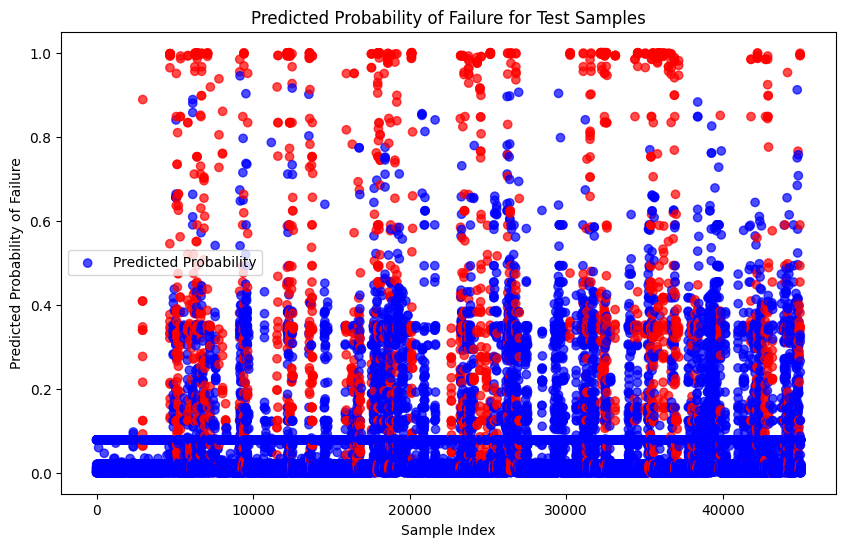

In [120]:
""" Results visulisation """

probabilities = model.predict(expanded_X_test)
predictions = (probabilities > 0.5).astype(int)

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(probabilities)), probabilities, c=y_test, cmap='bwr',
            alpha=0.7, label='Predicted Probability')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability of Failure')
plt.title('Predicted Probability of Failure for Test Samples')
plt.legend()
plt.show()

In [86]:
""" Single Prediction """

# Example current sequence: 1 sample with 15 features
current_sequence = np.random.rand(1, 15)

# Predict the probability of failure for the current sequence
probability_of_failure = model.predict(current_sequence)
print(f'Predicted Probability of Failure: {probability_of_failure[0][0]:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Probability of Failure: 0.0149
